<h1><center><u>Twitter Sentiment</u></center></h1>

<h5> This notebook takes a training csv file and creates a model based on positive or negative sentiment, which is then tested against a testing csv file using the saved model. </h5>

In [ ]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import re
import pickle
import seaborn as sns

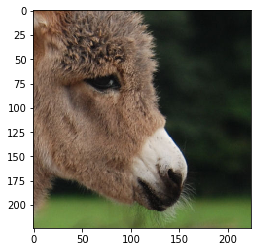

(100, 224, 224, 3)
(100, 1000)


In [26]:
from keras.applications.vgg16 import VGG16
import PIL
import matplotlib.pyplot as plt
import numpy as np


def pack_into_batch(image):
    all_images = []
    for _ in range(100):
        all_images.append(image)
        
    return np.array(all_images)



image = PIL.Image.open('/home/kainosaicamp/Downloads/Equus_asinus_Kadzidłowo_001.jpg')



image = image.resize((1355,907))
image = np.array(image)
# print(image.shape)
image = image[150:150+224, 900:900+224, :]

# 
# print(batch.shape)

plt.imshow(image)
plt.show()

model = VGG16(include_top=True, weights='imagenet')

image = np.array(image)
batch = pack_into_batch(image)
print(batch.shape)
image = image.reshape((1,224,224,3))

pred = model.predict(batch)
print(pred.shape)
# pred = pred.reshape((7,7,512))

In [27]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
top_10_indices = np.argsort(pred)[0][-10:]

print(top_10_indices)
# print(pred)

float_formatter = lambda x: "%.2f" % x

for item in pred[0][top_10_indices]:
    print(float_formatter(item))

print(float_formatter())


[181 331 146 349  99 145 347 355 296 348]
0.01
0.01
0.01
0.02
0.02
0.02
0.03
0.12
0.24
0.34


TypeError: <lambda>() takes exactly 1 argument (0 given)

In [ ]:
for ch in range(512):
    plt.imshow(pred[:,:,ch])
    plt.show()

## Load and Clean the Data
Load the data as before with pandas and take a look at the data so we know what we will be working with. 

To Do:
- Load the dataset into a dataframe with pandas
- Clean the data so it is easier to work with.

In [ ]:
train_tweets = pd.read_csv('train.csv')
test_tweets = pd.read_csv('test.csv')

train_tweets['SentimentText'] = train_tweets['SentimentText'].apply(lambda x: x.lower())
train_tweets['SentimentText'] = train_tweets['SentimentText'].apply(lambda x: re.sub('[^a-z0-9\s]', '', x))
train_tweets.head()
# test_tweets.head()

In [ ]:
sns.countplot(x = 'Sentiment', data = train_tweets)

## Tokenise
We are going to use tokenisation to find the 2000 most common words. Tokenising is used on a sequence of words (basically a sentence) to count their frequency. A *token* is an instance of a sequence of characters (basically a word). A type is the class of all tokens containing the same character sequence.

To Do:
- Define the max features
- Initialise a tokeniser with the max feature and a defined split
- Calculate the different word frequencies 
- Add padding to the sequences

In [ ]:
max_features = 2000

tokenizer = Tokenizer(num_words = max_features, split = ' ')
tokenizer.fit_on_texts(train_tweets['SentimentText'].values)

tweet_data = tokenizer.texts_to_sequences(train_tweets['SentimentText'].values)

In [ ]:
print tweet_data[0]
print tweet_data[12]

from keras.preprocessing.sequence import pad_sequences

tweet_data = pad_sequences(tweet_data)
print tweet_data[0]
print tweet_data[12]

## Build the Model 
As before define and build the model you want to train with this dataset. 

To Do:
- Define a sequential model and add your layers. 
- Compile the model
- (Optional) Display the layers with summary()

In [ ]:
embed_dim = 128
lstm_out = 128

model = Sequential()

model.add(Embedding(max_features, embed_dim, input_length = tweet_data.shape[1]))
model.add(Dropout(0.5))

model.add(Conv1D(64, 5, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 4))
model.add(Dropout(0.6))

model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

print model.summary()

## Split the Data and Train
Again we need to split the data so we have testing data and validation data to work with. The easiest way to do this is to make use of the scikit-learn library's function train_test_split.

To Do:
- Train the model with the data you have just organised

In [ ]:
Y = pd.get_dummies(train_tweets['Sentiment']).values

x_train, x_test, y_train, y_test = train_test_split(tweet_data,
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
partial_x_train = x_train[:5000]
partial_y_train = y_train[:5000]

partial_x_test = x_test[:5000]
partial_y_test = y_test[:5000]

batch_size = 500

model.fit(partial_x_train, 
          partial_y_train, 
          epochs = 10,
          batch_size = batch_size,
          validation_data = (partial_x_test, partial_y_test))

In [ ]:
model.save('tweet_sentiment_model.hdf5')

## Exercises

1. Using our trained model make a prediction against the test data.


In [ ]:
test_tweets['SentimentText'] = test_tweets['SentimentText'].apply(lambda x: x.lower())
test_tweets['SentimentText'] = test_tweets['SentimentText'].apply(lambda x: re.sub('[^a-z0-9\s]', '', x))
test_tweets.head()

max_features = 2000

tokenizer = Tokenizer(num_words = max_features, split = ' ')
tokenizer.fit_on_texts(test_tweets['SentimentText'].values)
tweet_data = tokenizer.texts_to_sequences(test_tweets['SentimentText'].values)

tweet_data = pad_sequences(tweet_data)

trained_model = load_model('tweet_sentiment_model.hdf5')


In [ ]:
prediction = trained_model.predict_classes(tweet_data[:1000])
# print(prediction)

y = train_tweets['Sentiment'].values

from sklearn.metrics import classification_report

print(classification_report(y[:1000], prediction))

2. Build another model and try and achieve a higher accuracy than us.